# Testing new AMM


In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

# Experiments
from model import run
from model import processing
#from model.plot_utils import *
from model import plot_utils as pu
from model import init_utils



########## AGENT CONFIGURATION ##########
# key -> token name, value -> token amount owned by agent
# note that token name of 'omniABC' is used for omnipool LP shares of token 'ABC'
# omniHDXABC is HDX shares dedicated to pool of token ABC
LP1 = {'omniR1': 500000}
LP2 = {'omniR2': 1500000}
trader = {'HDX': 1000000, 'R1': 1000000, 'R2': 1000000}

# key -> agent_id, value -> agent dict
agent_d = {'Trader': trader, 'LP1': LP1, 'LP2': LP2}
#agent_d = {'Trader': trader, 'LP1': LP1}


########## ACTION CONFIGURATION ##########

action_dict = {
    'sell_hdx_for_r1': {'token_buy': 'R1', 'token_sell': 'HDX', 'amount_sell': 2000, 'action_id': 'Trade', 'agent_id': 'Trader'},
    'sell_r1_for_hdx': {'token_sell': 'R1', 'token_buy': 'HDX', 'amount_sell': 1000, 'action_id': 'Trade', 'agent_id': 'Trader'},
    'provide_r1_liq': {'token_add': 'R1', 'amount_add': 100000, 'action_id': 'AddLiquidity', 'agent_id': 'LP1'},
    'remove_r1_liq': {'token_remove': 'R1', 'shares_remove': -100000, 'action_id': 'RemoveLiquidity', 'agent_id': 'LP1'}
}

# list of (action, number of repititions of action), timesteps = sum of repititions of all actions
trade_count = 5000
action_ls = [('trade', trade_count)]

# maps action_id to action dict, with some probability to enable randomness
prob_dict = {
    'trade': {'sell_hdx_for_r1': 0.5,
              'sell_r1_for_hdx': 0.5}
}



########## CFMM INITIALIZATION ##########

# Todo: generalize
initial_values = {
    'token_list': ['R1','R2'],
    'R': [500000,1500000],
    'P': [2,2/3],
    'fee_assets': 0,
    'fee_HDX': 0
}
#initial_values['H'] = [initial_values['Q'] * initial_values['W'][i] for i in range(len(initial_values['token_list']))]
#initial_values['D'] = copy.deepcopy(initial_values['H'])

#amms = [balancer_amm, reweighting_amm]
#amm_types = ['Balancer', 'Reweighting']
#amms = [reweighting_amm]
#amm_types = ['Reweighting']
#labels = amm_types
initial_list = []
config_params = {
    #'amm': amm,
    'cfmm_type': "",
    'initial_values': initial_values,
    'agent_d': agent_d,
    'action_ls': action_ls,
    'prob_dict': prob_dict,
    'action_dict': action_dict,
}

config_dict, state = init_utils.get_configuration(config_params)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()


The action at timestep 101 is: provide_r1_liq
The action at timestep 4901 is: remove_r1_liq
The action list lenght is: 5000

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Adding Liquidity
i is 0
{'R': [500051.5072055194, 1500000], 'Q': [999896.9961998368, 1000000.0], 'S': [500000, 1500000], 'B': [500000, 1500000], 'A': [0.0, 0], 'D': 0.0, 'token_list': ['R1', 'R2'], 'fee_assets': 0, 'fee_HDX': 0}
{'R': [500051.5072055194, 1500000], 'Q': [999896.9961998368, 1000000.0], 'S': [500000, 1500000], 'B': [500000, 1500000], 'A': [0.0, 0], 'D': 0.0, 'token_list': ['R1', 'R2'], 'fee_a

In [2]:
rdf, agent_df = processing.postprocessing(events)


In [3]:
%matplotlib inline



In [4]:
print(rdf.columns)

Index(['R-0', 'R-1', 'Q-0', 'Q-1', 'S-0', 'S-1', 'B-0', 'B-1', 'A-0', 'A-1',
       'D', 'token_list-0', 'token_list-1', 'fee_assets', 'fee_HDX', 'n',
       'simulation', 'subset', 'run', 'substep', 'timestep'],
      dtype='object')


In [5]:
rdf.head(101)

,R-0,R-1,Q-0,Q-1,S-0,S-1,B-0,B-1,A-0,A-1,...,token_list-0,token_list-1,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
2,501000.00,1500000,998003.99,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,1
4,499998.00,1500000,1000003.99,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,2
6,499000.01,1500000,1002003.99,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,3
8,498005.99,1500000,1004003.99,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4
10,499005.99,1500000,1001991.98,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,497051.51,1500000,1005931.97,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,97
196,498051.51,1500000,1003912.23,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,98
198,499051.51,1500000,1001900.59,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,99
200,500051.51,1500000,999897.00,1000000.00,500000.00,1500000,500000.00,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,100


In [6]:
rdf.tail(100)

,R-0,R-1,Q-0,Q-1,S-0,S-1,B-0,B-1,A-0,A-1,...,token_list-0,token_list-1,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
9802,472224.94,1500000,978237.19,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4901
9804,473224.94,1500000,976170.02,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4902
9806,474224.94,1500000,974111.57,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4903
9808,475224.94,1500000,972061.78,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4904
9810,476224.94,1500000,970020.59,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,480223.63,1500000,961943.50,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4996
9994,479227.26,1500000,963943.50,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4997
9996,480227.26,1500000,961936.23,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4998
9998,481227.26,1500000,959937.31,1000000.00,480597.55,1500000,485341.24,1500000,0.00,0,...,R1,R2,0,0,2,0,0,1,2,4999


In [7]:
agent_df.head(303)

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
6,0,0,1,2,1,Trader,1001996.01,0.00,0,999000.00,1000000,0.00,0.00
7,0,0,1,2,1,LP1,0.00,500000.00,0,0.00,0,2.00,0.00
8,0,0,1,2,1,LP2,0.00,0.00,1500000,0.00,0,0.00,0.67
12,0,0,1,2,2,Trader,999996.01,0.00,0,1000002.00,1000000,0.00,0.00
13,0,0,1,2,2,LP1,0.00,500000.00,0,0.00,0,2.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,0,0,1,2,100,LP1,0.00,500000.00,0,0.00,0,2.00,0.00
602,0,0,1,2,100,LP2,0.00,0.00,1500000,0.00,0,0.00,0.67
606,0,0,1,2,101,Trader,1000103.00,0.00,0,999948.49,1000000,0.00,0.00
607,0,0,1,2,101,LP1,0.00,599989.70,0,-100000.00,0,2.00,0.00


In [8]:
agent_df.tail(20)

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
29965,0,0,1,2,4994,LP1,0.00,495256.30,0,17270.90,0,1.82,0.00
29966,0,0,1,2,4994,LP2,0.00,0.00,1500000,0.00,0,0.00,0.67
29970,0,0,1,2,4995,Trader,992958.03,0.00,0,1003505.47,1000000,0.00,0.00
29971,0,0,1,2,4995,LP1,0.00,495256.30,0,17270.90,0,1.82,0.00
29972,0,0,1,2,4995,LP2,0.00,0.00,1500000,0.00,0,0.00,0.67
29976,0,0,1,2,4996,Trader,994965.33,0.00,0,1002505.47,1000000,0.00,0.00
29977,0,0,1,2,4996,LP1,0.00,495256.30,0,17270.90,0,1.82,0.00
29978,0,0,1,2,4996,LP2,0.00,0.00,1500000,0.00,0,0.00,0.67
29982,0,0,1,2,4997,Trader,992965.33,0.00,0,1003501.84,1000000,0.00,0.00
29983,0,0,1,2,4997,LP1,0.00,495256.30,0,17270.90,0,1.82,0.00


## Analysis

[0]


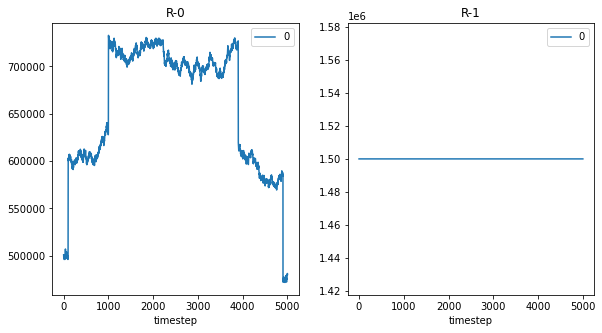

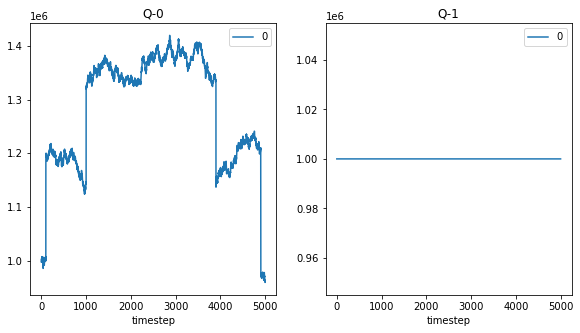

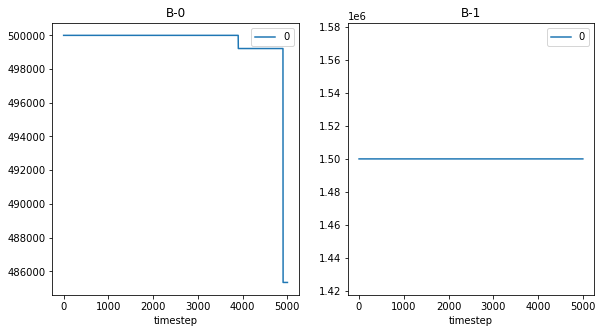

In [9]:
var_list = ['R', 'Q', 'B']
pu.plot_vars(rdf, var_list)


[0]


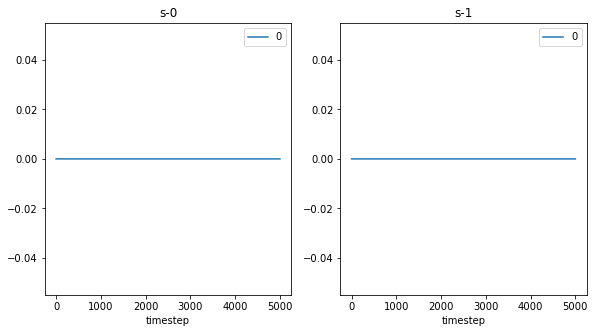

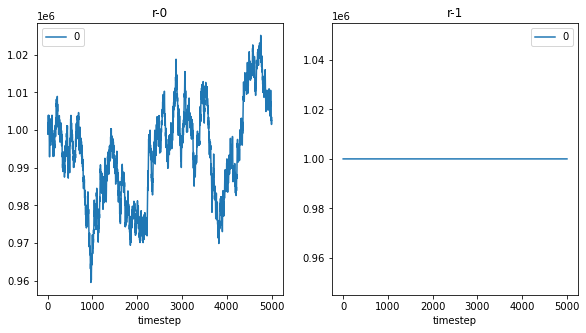

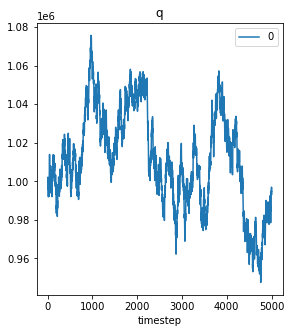

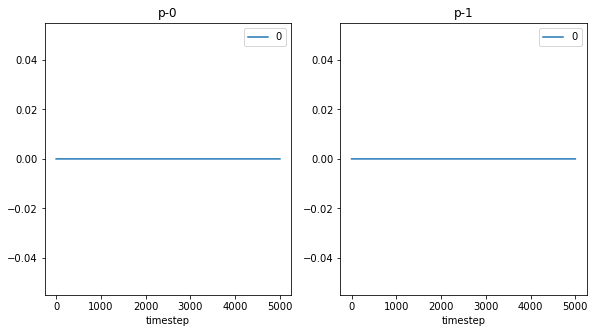

In [10]:
var_list = ['s', 'r', 'q', 'p']
trader_df = agent_df[agent_df['agent_label'] == 'Trader']
pu.plot_vars(trader_df, var_list)


[0]


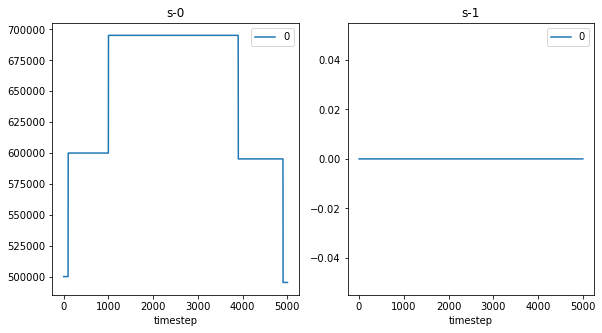

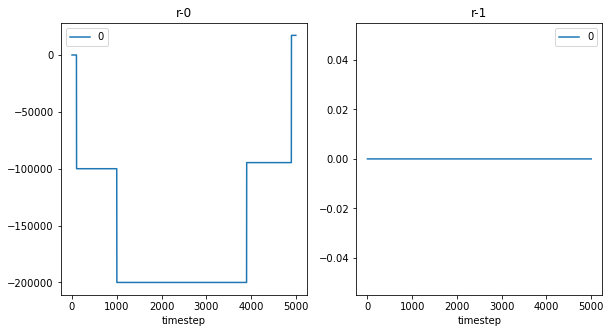

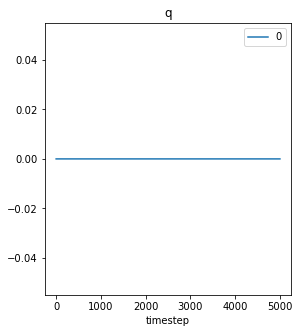

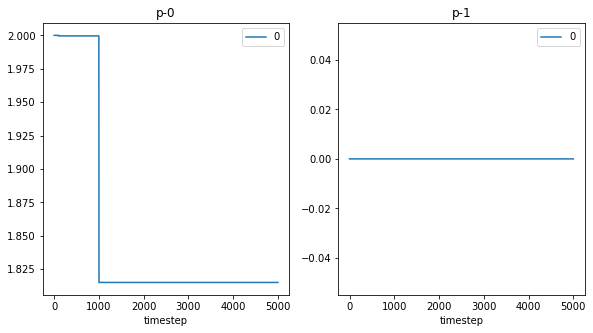

In [11]:
var_list = ['s', 'r', 'q', 'p']
LP1_df = agent_df[agent_df['agent_label'] == 'LP1']
pu.plot_vars(LP1_df, var_list)

In [12]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [13]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d
#val hold: withdraw liquidity at t=0, calculate value with prices at t
#val pool: withdraw liquidity at t, calculate value with prices at t

merged_df['val_pool'] = merged_df.apply(lambda x: processing.val_pool(x), axis=1)
withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
merged_df['val_hold'] = merged_df.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
merged_df['IL'] = merged_df.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
merged_df['pool_val'] = merged_df.apply(lambda x: processing.pool_val(x), axis=1)
merged_df['pool_loss'] = merged_df.apply(lambda x: x['pool_val']/2000000 - 1, axis=1)

merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val', 'p-0']].tail()


# compute val hold column


# compute val pool column

# compute IL

# plot Impermanent loss
# 

,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,val_pool,val_hold,IL,pool_val,p-0
14995,4999,LP1,0.00,959937.31,485341.24,495256.30,480597.55,17270.90,481227.26,283734.89,504274.47,-0.44,3975473.01,1.82
14996,4999,LP2,0.00,959937.31,485341.24,0.00,480597.55,0.00,481227.26,704540.77,1500000.00,-0.53,3975473.01,0.00
14997,5000,Trader,994971.51,961937.31,485341.24,0.00,480597.55,1002502.38,480226.72,3008150.77,3010650.23,-0.00,3975473.01,0.00
14998,5000,LP1,0.00,961937.31,485341.24,495256.30,480597.55,17270.90,480226.72,284405.25,505325.11,-0.44,3975473.01,1.82
14999,5000,LP2,0.00,961937.31,485341.24,0.00,480597.55,0.00,480226.72,704540.77,1500000.00,-0.53,3975473.01,0.00


In [14]:
merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head()


,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,val_pool,val_hold,IL,pool_val
0,1,Trader,1001996.01,998003.99,500000.00,0.00,500000.00,999000.00,501000.00,2999002.00,2998003.99,0.00,4000000.00
1,1,LP1,0.00,998003.99,500000.00,500000.00,500000.00,0.00,501000.00,235153.37,499002.00,-0.53,4000000.00
2,1,LP2,0.00,998003.99,500000.00,0.00,500000.00,0.00,501000.00,704540.77,1500000.00,-0.53,4000000.00
3,2,Trader,999996.01,1000003.99,500000.00,0.00,500000.00,1000002.00,499998.00,3000002.00,3000003.99,-0.00,4000000.00
4,2,LP1,0.00,1000003.99,500000.00,500000.00,500000.00,0.00,499998.00,235703.36,500002.00,-0.53,4000000.00


## Conclusion



[0]


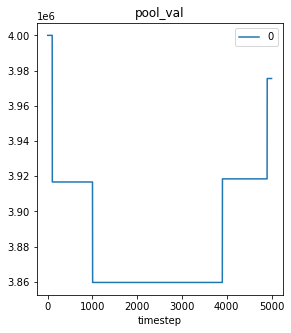

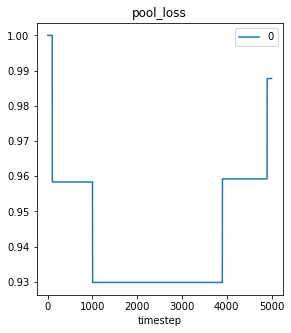

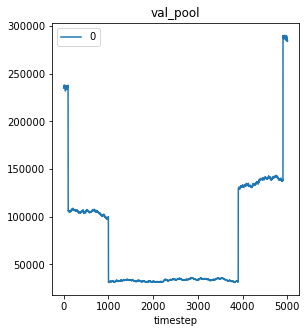

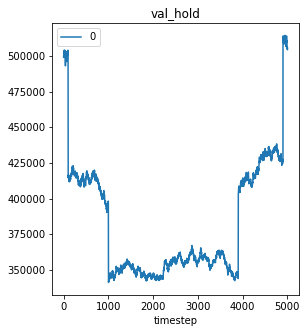

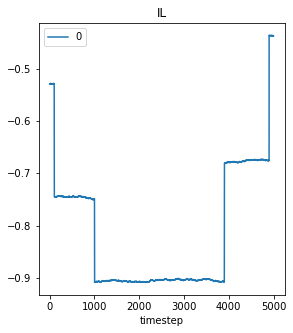

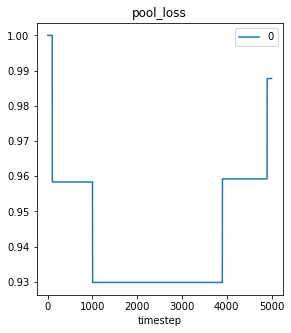

In [15]:
var_list = ['pool_val', 'pool_loss', 'val_pool', 'val_hold', 'IL', 'pool_loss']
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
pu.plot_vars(LP1_merged_df, var_list)